<h1>Titanic - Machine Learning from Disaster</h1>

In [134]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
import os


sns.set()

<h2>Loading Data</h2>

In [135]:
train = pd.read_csv("./data/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [136]:
test = pd.read_csv("./data/test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<h2>Exploring patterns: Survivability</h2>


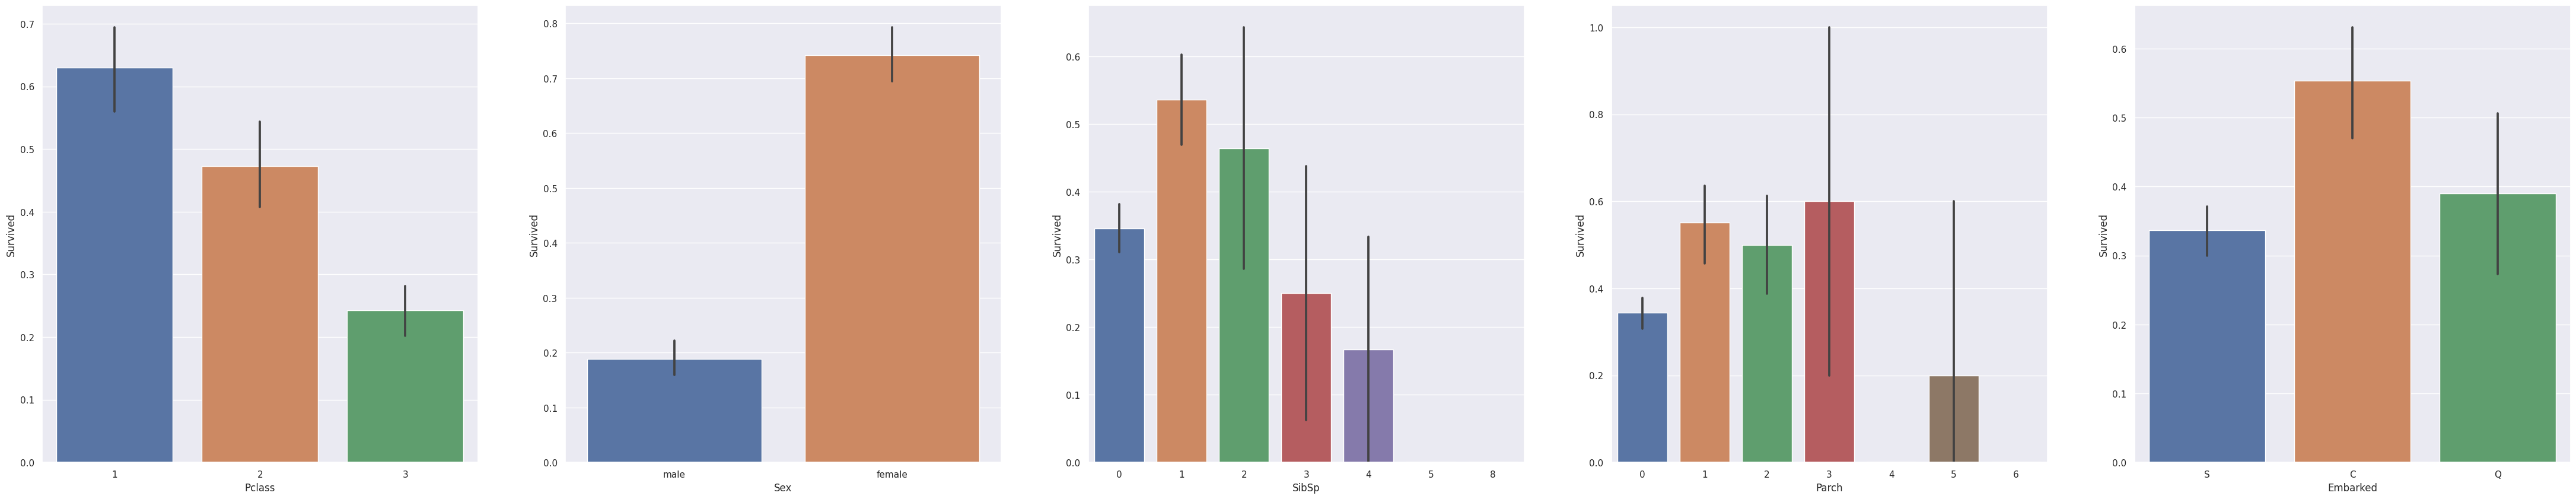

In [137]:
plt.figure(figsize = (55, 10))
cnt = 0
for i, label in enumerate(["Pclass", "Sex", "SibSp", "Parch", "Embarked"]):
    cnt += 1
    plt.subplot(1, 5, cnt)
    sns.barplot(x = label, y = "Survived", data=train)

<h2>Feature Engineering</h2>
<p>Add a new Title column to the dataset.</p>

In [138]:
def add_titles(df):
    titles = ["Mr", "Miss", "Mrs", "Master", "Jr"]

    df["Title"] = "U"

    for index, row in df.iterrows():
        for j in titles:
            if j in row["Name"]:
                df.loc[index, "Title"] = j
    return df
train = add_titles(train)
test = add_titles(test)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


<AxesSubplot:xlabel='Title', ylabel='Survived'>

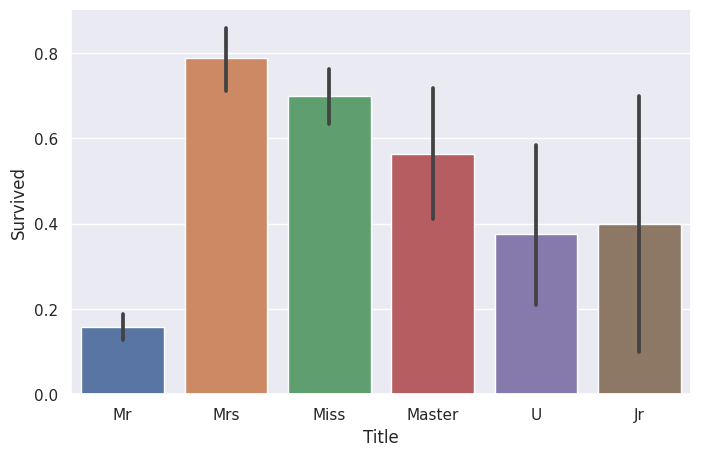

In [139]:
plt.figure(figsize = (8, 5))
sns.barplot(x = "Title", y = "Survived", data=train)

<h2>Data Cleaning</h2>

In [140]:
print(train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64


In [141]:
features = ["Pclass", "Age", "SibSp", "Parch", "Fare"]

def cleandata(df):
    df.loc[df["Embarked"].isnull(), "Embarked"] = 'U'

    df = df.join(pd.get_dummies(df.Embarked, prefix="Embarked"))
    df = df.drop('Embarked', axis=1)

    df = df.join(pd.get_dummies(df.Title, prefix="Title"))
    df = df.drop('Title', axis=1)

    df = df.join(pd.get_dummies(df.Sex))
    df = df.drop('Sex', axis=1)

    df.loc[:, features] = df[features].fillna(df[features].mean())

    return df
train_clean = cleandata(train)
test_clean = cleandata(test)

In [142]:
test_clean['Embarked_U'] = 0

features = ["Pclass", "female", "male", "Age", "SibSp", "Parch", "Fare", "Embarked_C", "Embarked_Q", "Embarked_S", "Embarked_U", "Title_Jr", "Title_Master", "Title_Miss", "Title_Mr", "Title_Mrs", "Title_U"]

<h2>Building the Machine Learning model</h2>

In [143]:
X_train = train_clean.loc[:, features]
y_train = train_clean.loc[:, "Survived"]

X_test = test_clean.loc[:, features]

X_train = np.asarray(X_train, dtype=float)
y_train = np.asarray(y_train, dtype=int)

X_test = np.asarray(X_test, dtype=float)

In [144]:
model = Sequential(
    [
        Dense(units = 35, activation = "relu", name = "L1"),
        Dense(units = 18, activation = "relu", name = "L2"),
        Dense(units = 1, activation = "sigmoid", name = "L3")
    ], name = "titanic_model"
)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer="Adam"
)

In [151]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
28/28 [==============================] - 0s 3ms/step - loss: 0.3564
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 0.3536
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 0.3541
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.3643
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.3515
Epoch 6/100
28/28 [==============================] - 0s 2ms/step - loss: 0.3485
Epoch 7/100
28/28 [==============================] - 0s 3ms/step - loss: 0.3497
Epoch 8/100
28/28 [==============================] - 0s 3ms/step - loss: 0.3519
Epoch 9/100
28/28 [==============================] - 0s 2ms/step - loss: 0.3479
Epoch 10/100
28/28 [==============================] - 0s 2ms/step - loss: 0.3543
Epoch 11/100
28/28 [==============================] - 0s 3ms/step - loss: 0.3591
Epoch 12/100
28/28 [==============================] - 0s 3ms/step - loss: 0.3478
Epoch 13/100
28/28 [=================

In [152]:
predictions = model.predict(X_test)

14/14 [==============================] - 0s 2ms/step


In [153]:
res = []
for i in predictions:
    res.append(1 if i > .5 else 0)

submission = pd.DataFrame({  "PassengerId": test_clean["PassengerId"],
                "Survived": res})
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [154]:
submission.to_csv("./data/submission.csv", sep=',', index=False)